### Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта: Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
Необходимо получить R2 > 0.6 на Private Leaderboard.

* **Примечание:** Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

#### Рекомендации для файла с кодом (ipynb):

1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения, которые были в курсе Python для Data Science. Градиентный бустинг изучается в последующих курсах, поэтому в этом проекте его применять не следует. Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

#### План проекта<a class='anckor' id='plan'>

* [1. Загрузка данных](#load)
* [2. EDA - разведочный анализ данных](#eda)
    - [оптимизация количественных переменных и уменьшение объёма занятой датафреймом памяти](#col)
        - [датафрейм для тренировки](#train_col)
        - [датафрейм для проверки](#test_col)
    - [анализ целевой переменной](#target)
    - [общий анализ количественных переменных](#analiz_col)
    - [корреляция признаков и анализ их влияния на целевую переменную](#corr)
    - [поиск пропусков и формирование идей по их ликвидации](#nulls)
        - [датафрейм для тренировки](#train_nulls)
        - [датафрейм для проверки](#test_nulls)
    - [поиск выбросов и формирование идей по их ликвидации](#ejection)
        - [датафрейм для тренировки](#train_ejection)
        - [датафрейм для проверки](#test_ejection)
    - [поиск категориальных признаков и формирование идей по их кодированию](#cat)
        - [датафрейм для тренировки](#train_cat)
        - [датафрейм для проверки](#test_cat)
    - [формирование идей для новых признаков](#new_variables)
* [3. Предобработка данных](#preprocessing)
    - [обработка выбросов](#process_ejection)
        - [датафрейм для тренировки](#process_train_ejection)
        - [датафрейм для проверки](#process_test_ejection)
    - [обработка пропусков](#process_nulls)
        - [датафрейм для тренировки](#process_train_nulls)
        - [датафрейм для проверки](#process_test_nulls)
    - [генерация новых признаков](#new_cat)
    - [отбор признаков](#feature_selection)
    - [сохранение предобработанных данных](#save_dataset)
    - [разделение датафрейма на train и valid](#separ)
* [4. Построение моделей](#models)
* [5. Обучение и валидация моделей](#train)
* [6. Определение важности признаков](#importance_signs)
* [7. Прогнозирование на тестовом датафрейме](#prediction)

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

### Созданные функции 

In [4]:
# Функция для поиска категорийных признаков в датасете
def find_cat(dataset):
    for name in dataset.columns:
        s = ''
        s += name
        if (type(dataset[name][0]) == str):
            s += ' строка,'
        if (dataset[name].nunique() < 4):
            s += ' мало уникальных значений'
        if (s != name):
            print(s)

In [5]:
# Функция для автоматического уменьшения объёма памати за счёт оптимизации количественных переменных датасета
def reduce_mem_usage(df):
    
    # Определение количество памяти занятой исходным датасетом
    start_mem = df.memory_usage().sum() / 1024**2
    print('Исходным датафреймом использована память в размере: {:.2f} MB'.format(start_mem))
    
    # итерация по признакам (столбцам) датасета
    for col in df.columns:
        col_type = df[col].dtype
        
        # для количественной переменной определяем min и max значения
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # для целочисленной переменной определяем оптимальный тип и меняем на него у признака
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)  # от -128 до 127 (1 байт)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)  # от -32768 до 32767 (2 байта)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # 4 байта
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  # 8 байтов
                    
            # для вещественной переменной определяем оптимальный тип и меняем на него у признака
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)  # 4 байта
                else:
                    df[col] = df[col].astype(np.float64)  # 8 байтов
        else:
            df[col] = df[col].astype('category')

    # Определение количество памяти занятой оптимизированным датасетом
    end_mem = df.memory_usage().sum() / 1024**2
    print('Оптимизированным датафреймом использована память в размере: {:.2f} MB'.format(end_mem))
    print('Использованная датафреймом память уменьшилась на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df.head()

In [6]:
# Функция для построения графиков
def display_outliers(df, data):
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    # Строим гистограмму для обнаружения выбросов у признака
    df[data].hist(bins=100, log=True)
    plt.title('Гистограмма с выбросами')

    plt.subplot(122)
    # Строим коробчатую диаграмму для обнаружения выбросов у признака
    df.boxplot(column=[data])
    plt.title('Коробчатая диаграмма')

In [7]:
# Функция для построения графиков
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)) + "\n" +
          "Train RMSE:\t" + str(round(np.sqrt(mse(train_true_values, train_pred_values)), 3)) + "\n" +
          "Train MSE:\t" + str(round(mse(train_true_values, train_pred_values), 3))
         )
    print()
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)) + "\n" +
          "Test RMSE:\t" + str(round(np.sqrt(mse(test_true_values, test_pred_values)), 3)) + "\n" +
          "Test MSE:\t" + str(round(mse(test_true_values, test_pred_values), 3))
         )
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к директориям и файлам

In [8]:
TRAIN_DATASET_PATH = './input/train.csv'
PREPARED_TRAIN_PATH = './input/train_sqr_prepared.csv'
TEST_DATASET_PATH = './input/test.csv'
PREPARED_TEST_PATH = './input/test_sqr_prepared.csv'

### Загрузка данных <a class='anchor' id='load'>

**Считываем данные для обучения.** 

Создаём датафрейм для обучения train_df из данных файла. По строкам - наблюдения, по столбцам - признаки. Выводим некоторое количество данных. Минимально знакомимся с датафреймом.

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [10]:
# Считываем данные. 2-е последние строки. 
train_df.tail(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [11]:
# Считываем данные. Случайная строка. 
train_df.sample()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9284,9470,77,3.0,50.623669,37.129826,6.0,4,9.0,1976,0.00007,B,B,46,10309,1,240.0,1,16,B,229768.874305


In [12]:
train_df.shape

(10000, 20)

In [13]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [14]:
train_df.index

RangeIndex(start=0, stop=10000, step=1)

**Считываем данные для тестирования.**

Создаём датафрейм для тренировки test_df из данных файла. По строкам - наблюдения, по столбцам - признаки. Выводим некоторое количество данных. Минимально знакомимся с датафреймом.

In [15]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [16]:
test_df.shape

(5000, 19)

In [17]:
test_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

[Вернуться к Плану проекта](#plan)

## 1. EDA  - исследовательский (разведочный) анализ данных<a class='anckor' id='eda'>
    
* оптимизация количественных признаков (уменьшение объёма памяти, который занимает датафрейм) 
* анализ целевой переменной:
    - регрессия - распределение, меры центральной тенденции
    - классификация - баланс классов
* анализ признаков в датасете:
    - корреляция признаков и анализ влияния на целевую переменную
    - поиск проблемных признаков
    - поиск пропусков и формирование идей по их ликвидации
    - поиск выбросов и формирование идей по их ликвидации
* анализ категориальных признаков:
    - поиск категориальных признаков их анализ
    - формирование идей по их кодированию
* формирование идей для новых признаков

### Количественные переменные<a class='anckor' id='col'>

#### Оптимизация количественных признаков для датафрейма train_df<a class='anckor' id='train_col'>

Проводим анализ количественных признаков, приводим к оптимальному типу с помощью функции **reduce_mem_usage(df)**.

In [18]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [19]:
# анализ признака 'Id' из датафрейма
sum(train_df['Id'].value_counts())

10000

Идентификационный номер квартиры **'Id'** является индивидуальным для каждой квартиры и не влияет на целевую переменную, следовательно изменим его тип на строковый.


In [20]:
train_df['Id'] = train_df['Id'].astype(str)

In [21]:
# уменьшаем объём памати за счёт оптимизации количественных переменных датафрейма
reduce_mem_usage(train_df)

Исходным датафреймом использована память в размере: 1.53 MB
Оптимизированным датафреймом использована память в размере: 0.82 MB
Использованная датафреймом память уменьшилась на 46.6%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [22]:
train_df.dtypes

Id               category
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

[Вернуться к Плану проекта](#plan)

#### Оптимизация количественных признаков для датафрейма test_df<a class='anckor' id='test_col'>

Проводим анализ количественных признаков, приводим к оптимальному типу с помощью функции **reduce_mem_usage(df)**.

In [23]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [24]:
test_df.shape

(5000, 19)

In [25]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [26]:
test_df['Id'] = test_df['Id'].astype(str)

In [27]:
reduce_mem_usage(test_df)

Исходным датафреймом использована память в размере: 0.72 MB
Оптимизированным датафреймом использована память в размере: 0.38 MB
Использованная датафреймом память уменьшилась на 47.7%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [28]:
test_df.dtypes

Id               category
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int16
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
dtype: object

[Вернуться к Плану проекта](#plan)

### Анализ целевой переменной<a class='anckor' id='target'>

Проводим анализ целевого признака 'Price'. Предварительный анализ целевой переменной показал, что она является количественной, непрерывной и вещественной. Создадим диаграмму распределения (регрессии) целевой переменной.

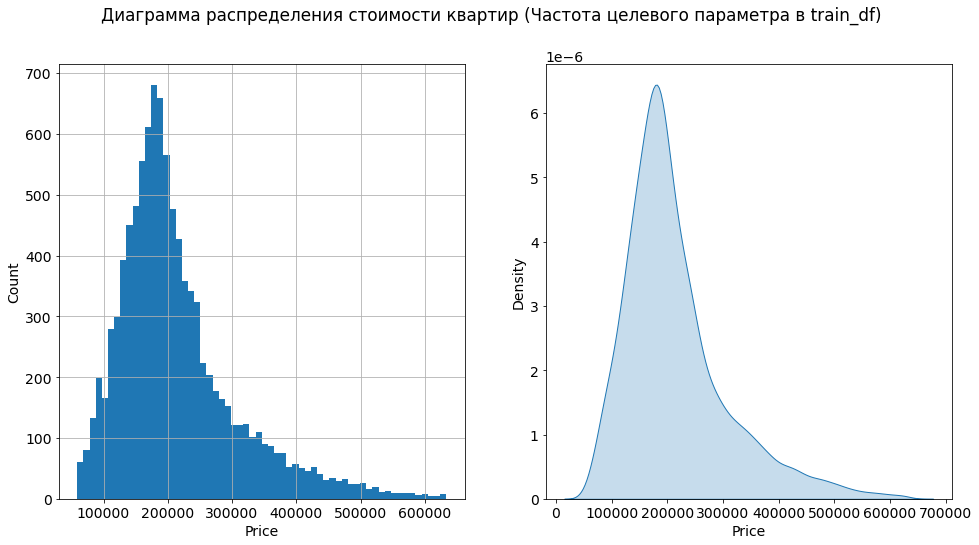

In [29]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(bins=60)
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Диаграмма распределения стоимости квартир (Частота целевого параметра в train_df)')
plt.show()


Расчёт статистических характеристик целевой переменной:

- минимальное значение **target_min**
- максимальное значение **target_max**
- среднее значение **target_mean**
- медиана **target_median**
- мода **target_median**

In [30]:
target_min = train_df['Price'].min()
target_max = train_df['Price'].max()
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]
target_min, target_max, target_mean, target_median, target_mode

(59174.77734375, 633233.4375, 214138.94, 192269.65625, 182938.08)

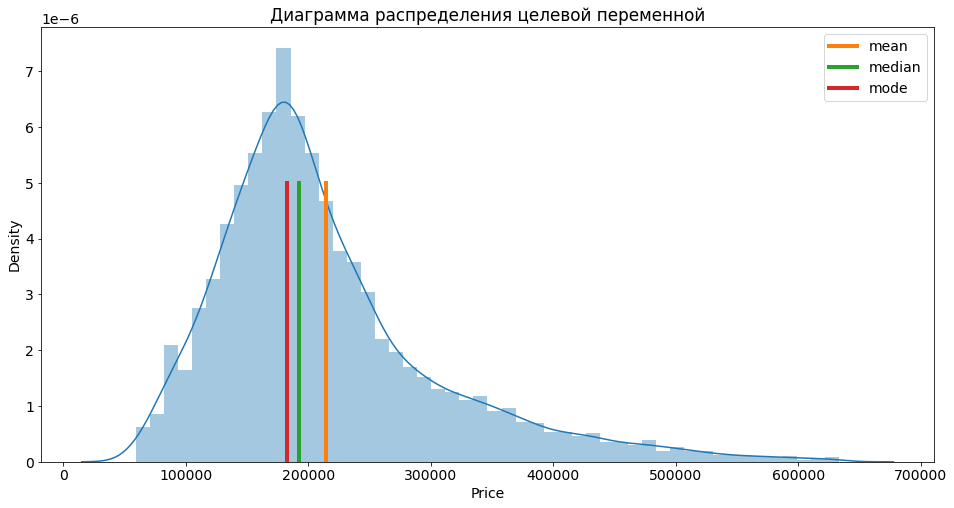

In [31]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.title('Диаграмма распределения целевой переменной')
plt.legend()
plt.show()

Анализ целевой переменной даёт понять:

- распределение имеет практически нормальный вид
- имеется небольшая аномалия в области максимального значения, что приводит смещение вправо

[Вернуться к Плану проекта](#plan)

## Общий анализ количественных переменных в датафрейме<a class='anckor' id='analiz_col'>
    
### train_df

In [32]:
train_df_num = train_df.select_dtypes(include=['int8', 'int16', 'int32', 'float32', 'float16'])
train_df_num.drop('Price', axis=1, inplace=True)
train_df_num.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6


In [33]:
train_df_num.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


Из общего анализа датафрейма train_df видно:
- имеются пропуска данных
- признак 'Rooms' имеет нулевое значение, что невозможно
- признаки 'Square', 'LifeSquare' и 'KitchenSquare', характеризующие площадь, имеют неестественные минимальные и максимальные значения, также имеют неправильную связь между собой
- признак 'HouseFloor' имеет нулевое значение, что невозможно
- признак 'HouseYear' имеют неестественное максимальное значение

### test_df

In [34]:
test_df_num = test_df.select_dtypes(include=['int8', 'int16', 'int32', 'float32', 'float16'])
test_df_num.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,24,4378,0,1036.0,1,1
1,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,2,629,1,NaN,0,0
2,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,9,1892,0,NaN,0,1
3,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,2,475,0,NaN,0,0
4,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,35,7715,4,990.0,0,6


In [35]:
test_df_num.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449512,36.158756,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,44.179466,0.838586,19.092773,17.825274,9.950069,5.483228,6.789165,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.745605,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Из общего анализа датафрейма test_df видно:
- имеются пропуска данных
- признак 'Rooms' имеет нулевое значение, что невозможно
- признаки 'Square', 'LifeSquare' и 'KitchenSquare', характеризующие площадь, имеют неестественные минимальные и максимальные значения, также имеют неправильную связь между собой
- признак 'HouseFloor' имеет нулевое значение, что невозможно

[Вернуться к Плану проекта](#plan)

### Корреляция признаков и анализ их влияния на целевую переменную<a class='anckor' id='corr'>

Корреляция независимых переменных с независимой (целевой) переменной. Сильной корреляция, когда значение приближается к 1 или −1, и о ее отсутствие, когда значение близко к нулю. Анализ корреляционной матрицы позволяет сделать вывод о линейной зависимости переменных.

In [36]:
# посчитаем коэффициент корреляции для всего датафрейма и округлим значение
corr_matrix = train_df.corr().round(2)
corr_matrix

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
DistrictId,1.00,0.07,-0.03,-0.02,0.04,-0.12,-0.15,0.01,0.07,0.25,0.17,0.14,0.30,0.31,0.17,0.27
Rooms,0.07,1.00,0.66,0.13,0.01,-0.00,-0.03,-0.01,-0.03,0.08,0.07,0.01,0.04,0.06,0.05,0.55
Square,-0.03,0.66,1.00,0.20,0.01,0.11,0.08,-0.01,-0.06,-0.07,-0.04,0.04,-0.04,-0.02,0.02,0.52
LifeSquare,-0.02,0.13,0.20,1.00,-0.00,0.02,0.03,-0.00,-0.02,-0.05,-0.04,0.01,-0.03,-0.02,-0.01,0.08
KitchenSquare,0.04,0.01,0.01,-0.00,1.00,-0.01,0.00,0.00,-0.01,0.04,0.04,-0.02,0.01,0.04,0.01,0.03
Floor,-0.12,-0.00,0.11,0.02,-0.01,1.00,0.42,0.00,-0.02,-0.04,-0.02,-0.00,-0.14,-0.07,0.02,0.13
HouseFloor,-0.15,-0.03,0.08,0.03,0.00,0.42,1.00,-0.00,-0.00,-0.02,0.01,-0.01,-0.14,-0.07,0.03,0.09
HouseYear,0.01,-0.01,-0.01,-0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,0.00,-0.01,0.01,0.00,0.00
Ecology_1,0.07,-0.03,-0.06,-0.02,-0.01,-0.02,-0.00,0.00,1.00,0.03,0.01,-0.12,-0.04,0.03,-0.08,-0.06
Social_1,0.25,0.08,-0.07,-0.05,0.04,-0.04,-0.02,0.00,0.03,1.00,0.96,0.02,0.08,0.52,0.53,0.26


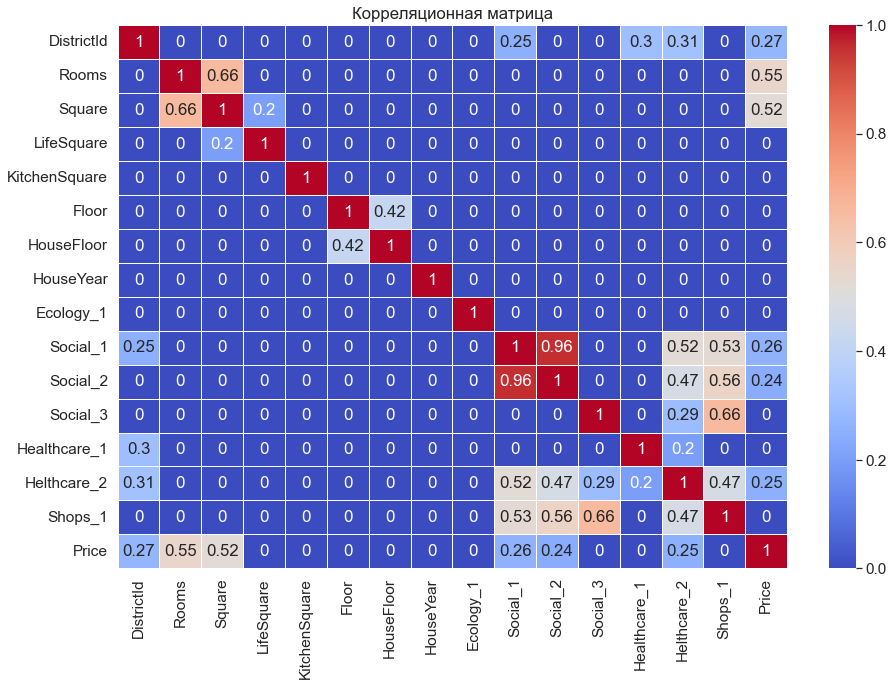

In [37]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Корреляционная матрица')
plt.show()

Из корреляционной матрицы видно, что:
- умеренная корреляция наблюдается у переменных: Rooms, Square; 
- слабая корреляция у переменных: DistrictId, Social_1, Social_2, Helthcare_2;
- очень слабая или отсутствует у переменных: LifeSquare, KitchenSquare, HouseFloor, HouseYear, Shops_1, Healthcare_1, Floor, Ecology_1, Social_3;
- также имеется взаимная корреляция у пар признаков:
    * Rooms - Square; HouseFloor - Floor; Social_1 - Social_2; Social_1 - Helthcare_2; Social_1 - Shops_1;
    * Social_2 - Helthcare_2; Social_2 - Shops_1; Social_3 - Shops_1;


**Вывод:**

   - необходимо провести анализ переменных с умеренной корреляцией **Rooms** и **Square** на предмет пропусков и выбросов;
   - для переменных со слабой корреляцией **HouseFloor** и **HouseYear** тоже необходимо провести анализ на предмет пропусков и выбросов, т.к. они могут влиять на стоимость квартиры сильнее при устранении ошибок;
   - переменные с очень слабой корреляцией можно из датафрейма удалить;
   - переменные Social_1 и Social_2 очень сильно связаны между собой, в связи с этим Social_2, с меньшей зависимостью на целевую переменную, можно удалить из датафрейма для обучения. 

[Вернуться к Плану проекта](#plan)

### Поиск пропусков и формирование идей по их ликвидации<a class='anckor' id='nulls'>

#### Поиск пропусков в датафрейме train_df<a class='anckor' id='train_nulls'>
    
    вывод концентрации пропусков в абсолютном значении и процентах для каждого признака 
    **(если пропусков у признака > 70%, то такой признак удаляем)**

In [38]:
# Концентрация пропусков в абсолютном значении в датафрейме train_df
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [39]:
# Концентрация пропусков в процентах в датафрейме train_df
train_df.isnull().mean() * 100

Id                0.00
DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       21.13
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.98
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
Price             0.00
dtype: float64

Переменная LifeSquare, имеющая 21,13% пропусков, согласно корреляционной матрицы на целевую переменную имеет очень слабое влияние. В связи с этим можно не обрабатывать пропуски, а удалим этот признак. Мы же заменим пропуски значением равным 70% от признака Square в текущей записи после исправления выбросов.

[Перейти к обработе пропусков](#train_LifeSquare_nulls)

Переменная Healthcare_1, имеющая 47.98% пропусков, согласно корреляционной матрицы на целевую переменную имеет слабое влияние. В связи с этим мы поэкспериментируем с заменой пропусков на значения: min, median или mean, что может усилить влияние на целевую переменную.

[Перейти к обработе пропусков](#train_Healthcare_1_nulls)

#### Поиск пропусков в датафрейме test_df<a class='anckor' id='test_nulls'>


In [40]:
# Концентрация пропусков в абсолютном значении в датафрейме test_df
test_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [41]:
# Концентрация пропусков в процентах в датасете test_df
test_df.isnull().mean() * 100

Id                0.00
DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       20.82
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.54
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
dtype: float64

Переменная LifeSquare, имеющая 20.82% пропусков. Заполним пропуска значением равным 70% от признака Square в текущей записи после исправления выбросов.

[Перейти к обработе пропусков](#test_LifeSquare_nulls)

Переменная Healthcare_1, имеющая 47.54% пропусков. Заполним пропуска значением, которым заполняли пропуска в датафрейме train_df.

[Перейти к обработе пропусков](#test_Healthcare_1_nulls)

[Вернуться к Плану проекта](#plan)

## Поиск выбросов и формирование идей по их ликвидации<a class='anckor' id='ejection'>

#### Обнаружение выбросов в количественных переменных датафрейма train_df<a class='anckor' id='train_ejection'>

In [42]:
train_df.describe().round(3)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000,10000.00,10000.000,7887.000,10000.000,10000.000,10000.000,1.000000e+04,10000.000,10000.000,10000.000,10000.000,5202.000,10000.000,10000.000,10000.000
mean,50.401,1.89,56.316,37.200,6.273,8.527,12.609,3.990166e+03,0.119,24.687,5352.157,8.039,1142.904,1.320,4.231,214138.938
std,43.588,0.84,21.059,86.241,28.561,5.241,6.776,2.005003e+05,0.119,17.533,4006.800,23.832,1021.519,1.494,4.806,92872.273
min,0.000,0.00,1.137,0.371,0.000,1.000,0.000,1.910000e+03,0.000,0.000,168.000,0.000,0.000,0.000,0.000,59174.777
25%,20.000,1.00,41.775,22.770,1.000,4.000,9.000,1.974000e+03,0.018,6.000,1564.000,0.000,350.000,0.000,1.000,153872.629
50%,36.000,2.00,52.513,32.781,6.000,7.000,13.000,1.977000e+03,0.075,25.000,5285.000,2.000,900.000,1.000,3.000,192269.648
75%,75.000,2.00,65.901,45.129,9.000,12.000,17.000,2.001000e+03,0.196,36.000,7227.000,5.000,1548.000,2.000,6.000,249135.461
max,209.000,19.00,641.065,7480.592,2014.000,42.000,117.000,2.005201e+07,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000,633233.438


Предварительная оценка признаков на выбросы с помощью метода describe().
* Rooms - имеет выброс по минимальному значению, т.к. количество комнат должно быть 1 и более;
* Square - имеет выброс по минимальному значению, т.к. общая площадь должна быть 10 и более;
* LifeSquare - имеет выброс по минимальному и максимальному значениям, т.к. жилая площадь должна быть 10 и более и не должна быть больше общей площади;
* KitchenSquare - имеет выброс по минимальному и максимальному значениям, т.к. площадь кухни должна быть 4 и более и не должна быть больше общей площади;
* HouseFloor - имеет выброс по минимальному значению, т.к. количество этажей в доме должно быть 1 и более;
* HouseYear - имеет выброс по максимальному значению, т.к. год постройки дома не должен превышать 2020;
* Floor, Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Price - не имеют выбросы

Проведём более подробную оценку выбросов для признаков: **Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear.** 

### Rooms<a class='anckor' id='Rooms_train_analysis'>

In [43]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [44]:
train_df[(train_df['Rooms'] > 5) | (train_df['Rooms'] == 0)].shape

(12, 20)

Выбросы с Rooms > 5 и  Rooms = 0 можно удалить из датафрейма, т.к. их количество незначительное.

[Перейти к обработе выброса](#Rooms_train_ejection)

### Square<a class='anckor' id='Square_train_analysis'>

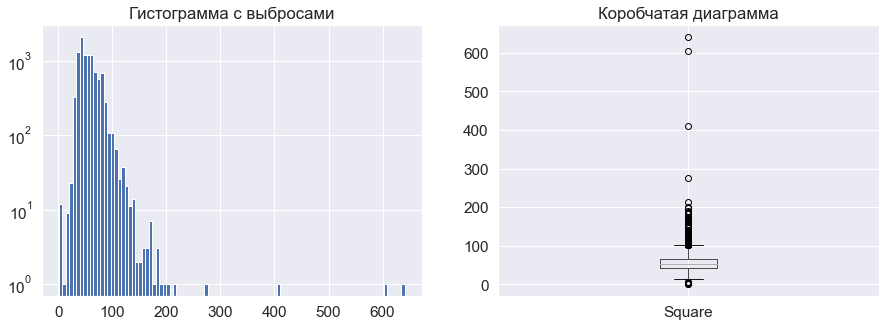

In [45]:
display_outliers(train_df, 'Square')

In [46]:
train_df[train_df['Square'] < 10].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.18750
328,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.06250
1401,9487,5,1.0,5.129221,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.40625
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.78125
4800,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.50000


In [47]:
train_df[train_df['Square'] < 10].shape

(12, 20)

In [48]:
train_df[train_df['Square'] > 250]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
726,28,9,2.0,604.705994,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.250000
1906,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.875000
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
9229,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500


Выбросы с Square < 10 и Square > 250 удалим из датасета, т.к. их количество незначительное.

После исправления выбросов для переменных Rooms и Square необходимо провести анализ соответствия этих переменных друг другу, т.к. они тесно связаны между собой, и исправить несоответствие.

[Перейти к обработе выброса](#Square_train_ejection)

### KitchenSquare<a class='anckor' id='KitchenSquare_train_analysis'>

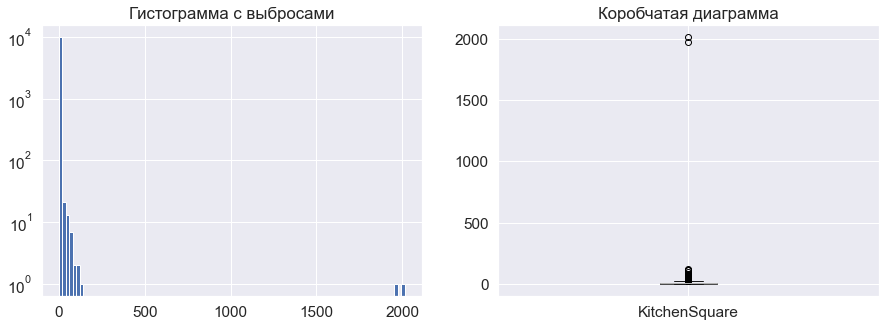

In [49]:
display_outliers(train_df, 'KitchenSquare')

In [50]:
train_df[train_df['KitchenSquare'] < 5].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
8,9951,1,1.0,46.887894,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.406250
9,8094,6,3.0,79.867477,75.085129,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.031250
18,4581,1,1.0,47.582481,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593750
19,367,45,1.0,42.367290,40.012527,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.984375


In [51]:
train_df[train_df['KitchenSquare'] < 5].shape

(3222, 20)

In [52]:
train_df[train_df['KitchenSquare'] > 25].shape

(41, 20)

Переменная KitchenSquare оказывает слабое влияние на целевую переменную, в связи с этим выброс её можно удалить. Однако она может влиять на выбор квартиры клиентом, в связи с этим её выбросы заменим на значения согласно логике:

- для KitchenSquare < 5 = 15% от общей площади квартиры;
- для KitchenSquare > 25 = 15% от общей площади квартиры.

[Перейти к обработе выброса](#KitchenSquare_train_ejection)

### LifeSquare<a class='anckor' id='LifeSquare_train_analysis'>

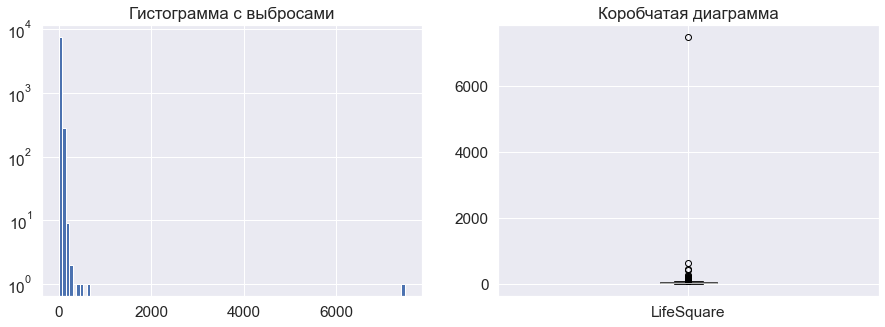

In [53]:
display_outliers(train_df, 'LifeSquare')

In [54]:
train_df[train_df['LifeSquare'] < 10].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,8553,88,3.0,83.262527,4.769175,1.0,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.906250
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174742.000000
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.187500
212,1182,27,1.0,38.936985,3.064320,0.0,18,19.0,2017,0.211401,B,B,9,1892,0,NaN,0,1,B,93560.789062
227,3746,62,1.0,46.722042,1.944446,1.0,11,12.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,133721.125000


In [55]:
train_df[train_df['LifeSquare'] < 10].shape

(205, 20)

In [56]:
train_df[train_df['LifeSquare'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
357,14990,23,2.0,48.449875,263.542023,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.234375
1776,16568,27,4.0,200.334534,201.627365,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.500000
1906,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.875000
5183,15886,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.312500
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
7644,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
8000,16550,27,3.0,81.694420,7480.592285,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.500000
9229,11602,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500


Выбросы переменной LifeSquare заменим на значения согласно логике:

- для LifeSquare < 10 = 70% от общей площади квартиры;
- для LifeSquare > 200 - удалим;
- для LifeSquare >= Square = 70% от общей площади квартиры.

[Перейти к обработе выброса](#LifeSquare_train_ejection)

### HouseFloor<a class='anckor' id='HouseFloor_train_analysis'>

In [57]:
train_df[train_df['HouseFloor'] == 0].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
24,4717,27,1.0,44.203945,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.562500
152,12947,53,2.0,56.023342,NaN,0.0,14,0.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,247074.562500
159,13146,74,1.0,46.449711,NaN,0.0,6,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.453125
186,12174,62,1.0,44.954880,NaN,0.0,8,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,133773.296875
229,15661,45,3.0,81.094925,NaN,0.0,15,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,442472.468750


In [58]:
train_df[train_df['HouseFloor'] == 0].shape

(269, 20)

Переменная HouseFloor оказывает слабое влияние на целевую переменную, но имеет большое количество выбросов, при исправлении которых может усилится влияние. В связи с этим выброс = 0 заменим на значения согласно логике:

- HouseFloor = mean_floor - для квартир с Floor < mean_floor;
- HouseFloor = Floor - для квартир с Floor > mean_floor.

[Перейти к обработе выброса](#HouseFloor_train_ejection)

### HouseYear<a class='anckor' id='HouseYear_train_analysis'>

In [59]:
train_df[train_df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375
9163,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250


Переменная HouseYear оказывает слабое влияние на целевую переменную, но имеет два выброса, при исправлении которых может усилится влияние. В связи с этим выброс > 2020 заменим на среднее значение года постройки дома без учета этих выбросов.

[Перейти к обработе выброса](#HouseYear_train_ejection)

[Вернуться к Плану проекта](#plan)

## Обнаружение выбросов в количественных переменных датарейма test_df<a class='anckor' id='test_ejection'>

In [60]:
test_df.describe().round(3)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000,5000.000,5000.000,3959.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,2623.000,5000.000,5000.000
mean,51.279,1.910,56.450,36.159,5.977,8.632,12.601,1984.393,0.120,24.934,5406.900,8.263,1146.657,1.319,4.243
std,44.179,0.839,19.093,17.825,9.950,5.483,6.789,18.573,0.120,17.532,4026.615,23.864,1044.746,1.480,4.777
min,0.000,0.000,1.379,0.333,0.000,1.000,0.000,1908.000,0.000,0.000,168.000,0.000,0.000,0.000,0.000
25%,21.000,1.000,41.906,23.092,1.000,4.000,9.000,1973.000,0.020,6.000,1564.000,0.000,325.000,0.000,1.000
50%,37.000,2.000,52.921,32.925,6.000,7.000,12.000,1977.000,0.072,25.000,5285.000,2.000,900.000,1.000,3.000
75%,77.000,2.000,66.285,45.174,9.000,12.000,17.000,2000.000,0.196,36.000,7287.000,5.000,1548.000,2.000,6.000
max,212.000,17.000,223.454,303.071,620.000,78.000,99.000,2020.000,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000


Предварительная оценка признаков датарейма **test_df** на выбросы с помощью метода describe().
* Rooms - имеет выброс по минимальному значению, т.к. количество комнат должно быть 1 и более;
* Square - имеет выброс по минимальному значению, т.к. общая площадь должна быть 10 и более;
* LifeSquare - имеет выброс по минимальному и максимальному значениям, т.к. жилая площадь должна быть 10 и более и не должна быть больше общей площади;
* KitchenSquare - имеет выброс по минимальному и максимальному значениям, т.к. площадь кухни должна быть 5 и более и не должна быть больше общей площади;
* HouseFloor - имеет выброс по минимальному значению, т.к. количество этажей в доме должно быть 1 и более;
* Floor, HouseYear, Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1 - не имеют выбросы

Проведём более подробную оценку выбросов для признаков: **Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear.** 

### Rooms<a class='anckor' id='Rooms_test_analysis'>

In [61]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

У переменной Rooms в датафрейме test_df имеются 3-и значения с выбросами: Rooms=0 - 2, Rooms=17 - 1. Заменим эти значения на среднее из датафрейма train_df.

[Перейти к обработе выброса](#Rooms_test_ejection)


### Square<a class='anckor' id='Square_test_analysis'>

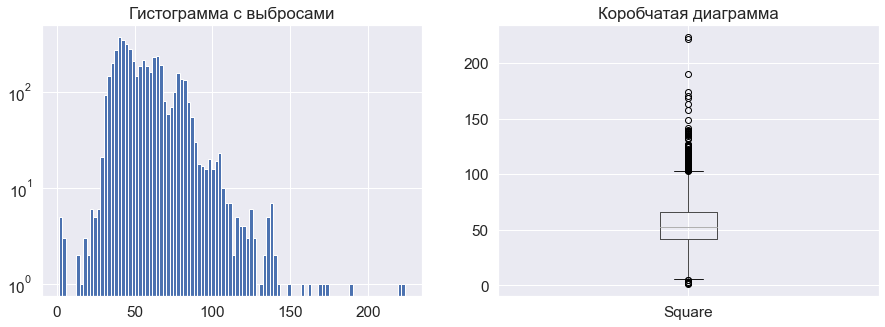

In [62]:
display_outliers(test_df, 'Square')

In [63]:
test_df[test_df['Square'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
131,16401,30,1.0,2.645046,4.338756,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
571,170,6,2.0,2.900586,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B
996,2138,27,1.0,5.647459,1.501582,1.0,1,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
1672,1420,45,1.0,1.975769,2.900371,1.0,1,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B
2051,10120,6,1.0,5.100671,3.861780,1.0,3,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
2463,9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
3608,1165,27,1.0,2.372101,1.899119,1.0,2,17.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B
4193,7855,6,1.0,4.967143,2.968086,1.0,3,1.0,2018,0.243205,B,B,5,1564,0,540.0,0,0,B


In [64]:
test_df[(test_df['Square'] > 150)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
241,16053,17,4.0,168.729034,169.901703,0.0,4,0.0,2013,0.093443,B,B,23,4635,5,3300.0,2,4,B
956,4058,27,6.0,223.453690,104.113556,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
1377,3357,27,3.0,170.476318,75.973610,8.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
1929,12316,183,5.0,157.976105,101.040482,12.0,7,8.0,1908,0.246624,B,B,14,2940,45,NaN,3,6,B
2716,14498,23,1.0,163.325897,NaN,1.0,3,1.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B
4402,1397,76,3.0,221.138763,118.055344,4.0,32,48.0,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
4549,13589,27,3.0,173.974472,76.289474,9.0,3,3.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
4852,7769,124,4.0,189.679581,114.708672,4.0,19,40.0,2013,0.174739,B,B,17,3379,9,100.0,0,3,B


Для выбросов переменной Square < 10 и Square > 150 проведём замену по схеме:

- Square = square_mean - среднее значение площади для однотипных квартир из датафрейма для обучения.

[Перейти к обработке выброса](#Square_test_ejection)

### LifeSquare<a class='anckor' id='LifeSquare_test_analysis'>

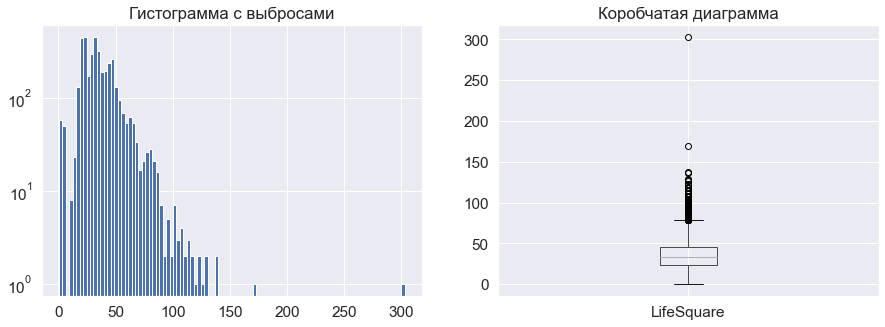

In [65]:
display_outliers(test_df, 'LifeSquare')

In [66]:
test_df[test_df['LifeSquare'] < 10].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
17,6791,1,3.0,72.023277,2.470856,1.0,4,24.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
31,3340,27,3.0,69.921936,3.986053,1.0,9,17.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
131,16401,30,1.0,2.645046,4.338756,1.0,2,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
135,3798,30,2.0,39.187588,5.199864,1.0,4,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B
265,6428,9,1.0,43.037262,3.013165,1.0,3,1.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B


In [67]:
test_df[test_df['LifeSquare'] < 10].shape

(110, 19)

In [68]:
test_df[test_df['LifeSquare'] > test_df['Square']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
25,14686,1,3.0,77.229889,79.958687,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
28,10869,23,3.0,78.001884,82.566322,1.0,21,25.0,2015,0.075779,B,B,6,1437,3,NaN,0,2,B
39,16384,1,2.0,52.773670,52.910721,10.0,6,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
48,15509,27,2.0,55.439861,57.527245,10.0,15,17.0,2016,0.011654,B,B,4,915,0,NaN,0,0,B


In [69]:
test_df[test_df['LifeSquare'] > test_df['Square']].shape

(241, 19)

Переменная LifeSquare оказывает слабое влияние на целевую переменную, в связи с этим её можно удалить. Однако она может влиять на выбор квартиры клиентом, в связи с этим её выбросы заменим на значения согласно логике:

- для LifeSquare < 10 = 70% от общей площади квартиры;
- для LifeSquare >= Square = 70% от общей площади квартиры.

[Перейти к обработе выброса](#LifeSquare_test_ejection)

### KitchenSquare<a class='anckor' id='KitchenSquare_test_analysis'>

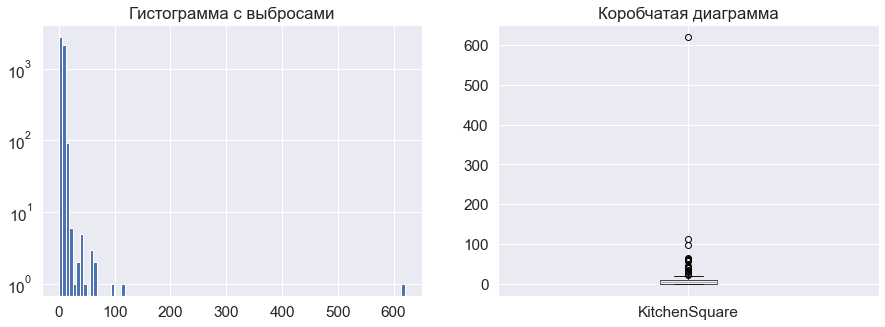

In [70]:
display_outliers(test_df, 'KitchenSquare')

In [71]:
test_df[test_df['KitchenSquare'] < 5].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
11,13270,9,3.0,80.599472,NaN,1.0,4,1.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
13,16751,74,1.0,54.614170,NaN,1.0,8,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
14,11404,27,1.0,44.415508,NaN,1.0,14,1.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
16,14925,22,2.0,61.413582,NaN,1.0,13,17.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B


In [72]:
test_df[test_df['KitchenSquare'] < 5].shape

(1562, 19)

In [73]:
test_df[test_df['KitchenSquare'] > 25].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
337,10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,B,B,31,6119,4,NaN,1,2,B
544,12612,27,2.0,60.988495,33.646725,60.0,5,17.0,2013,0.072158,B,B,2,629,1,NaN,0,0,A
683,1968,27,2.0,138.039185,92.484100,42.0,3,3.0,2016,0.014073,B,B,2,475,0,NaN,0,0,B
972,5428,27,2.0,62.326042,NaN,61.0,12,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
1117,3747,23,5.0,139.045761,89.790276,42.0,1,3.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B


In [74]:
test_df[test_df['KitchenSquare'] > 25].shape

(17, 19)

Переменная KitchenSquare оказывает слабое влияние на целевую переменную, в связи с этим выброс её можно удалить. Однако она может влиять на выбор квартиры клиентом, в связи с этим её выбросы заменим на значения согласно логике:

- для KitchenSquare < 5 = 15% от общей площади квартиры;
- для KitchenSquare > 25 = 15% от общей площади квартиры.

[Перейти к обработке выброса](#KitchenSquare_test_ejection)

### HouseFloor<a class='anckor' id='HouseFloor_test_analysis'>

In [75]:
test_df[test_df['HouseFloor'] == 0].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
52,15989,62,1.0,47.095406,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
61,12694,27,3.0,83.670029,46.358356,0.0,8,0.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A
93,6257,62,1.0,43.835918,NaN,0.0,9,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
95,902,27,3.0,99.293190,NaN,0.0,2,0.0,1977,0.075424,B,B,11,3097,0,NaN,0,0,B
164,2559,23,2.0,73.868462,NaN,0.0,9,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B


In [76]:
test_df[test_df['HouseFloor'] == 0].shape

(131, 19)

Выброс HouseFloor = 0 заменим на значения согласно логике:

- HouseFloor = mean_floor - для квартир с Floor < mean_floor;
- HouseFloor = Floor - для квартир с Floor > mean_floor.

[Перейти к обработке выброса](#HouseFloor_test_ejection)

[Вернуться к Плану проекта](#plan)

## Анализ категориальных признаков<a class='anckor' id='cat'>

#### Поиск и анализ категориальных переменных датафрейма train_df<a class='anckor' id='train_cat'>|

Для поиска будем использовать функцию find_cat

In [77]:
find_cat(train_df)

Id строка,
Ecology_2 строка, мало уникальных значений
Ecology_3 строка, мало уникальных значений
Shops_2 строка, мало уникальных значений


In [78]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [79]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [80]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

В нашем датасете признаки Ecology_2, Ecology_3 и Shops_2 являются категориальными. Для кодирования этих признаков будем использовать **Унитарное кодирование (One Hot Encoding)**

#### Поиск и анализ категориальных переменных датафрейма test_df<a class='anckor' id='test_cat'>|

Для поиска будем использовать функцию find_cat

In [81]:
find_cat(test_df)

Id строка,
Ecology_2 строка, мало уникальных значений
Ecology_3 строка, мало уникальных значений
Shops_2 строка, мало уникальных значений


In [82]:
test_df['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [83]:
test_df['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [84]:
test_df['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

В нашем датафрейме признаки Ecology_2, Ecology_3 и Shops_2 являются категориальными. Для кодирования этих признаков будем использовать **Унитарное кодирование (One Hot Encoding)**

### Формирование идей по созданию новых признаков<a class='anckor' id='new_variables'>
    
За целевую переменную можно использовать не стоимость квартиры, а стоимость квадратного метра.
    **Price_sqr_meter = Price / Square**

[Вернуться к Плану проекта](#plan)

# Предобработка данных<a class='anckor' id='preprocessing'>
    


[Вернуться к Плану проекта](#plan)

## Обработка выбросов <a class='anckor' id='process_ejection'>
    
### Обработка выбросов датафрейма train_df<a class='anckor' id='process_train_ejection'>

In [85]:
train_df_pre = train_df.copy()
test_df_pre = test_df.copy()

### Rooms<a class='anckor' id='Rooms_train_ejection'>
    
[Вернуться к анализу выброса](#Rooms_train_analysis)

Выбросы с Rooms > 5 и  Rooms = 0 можно удалить из датафрейма, т.к. их количество незначительное.

In [86]:
# поиск индексов строк, которые удовлетворяют нашему критерию отбора: Rooms > 5 или Rooms == 0
index_drop = train_df_pre[(train_df_pre['Rooms'] == 0) | (train_df_pre['Rooms'] > 5)].index
index_drop

Int64Index([2004, 2194, 2728, 3780, 5894, 6088, 6401, 7644, 7929, 8794, 9767,
            9869],
           dtype='int64')

In [87]:
# удаление строк из датасета по найденным индексам
train_df_pre = train_df_pre.drop(index_drop, axis=0)
train_df_pre[(train_df_pre['Rooms'] == 0) | (train_df_pre['Rooms'] >5)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


### Square<a class='anckor' id='Square_train_ejection'>

[Вернуться к анализу выброса](#Square_train_analysis)
    
    
Выбросы с Square > 250 и  Square < 10 можно удалить из датафрейма, т.к. их количество незначительное.

После исправления выбросов для переменных Rooms и Square необходимо провести анализ соответствия этих переменных друг другу, т.к. они тесно связаны между собой, и исправить несоответствие.


In [88]:
# поиск индексов строк, которые удовлетворяют нашему критерию отбора: Square > 250 или Square < 10
index_drop = train_df_pre[(train_df_pre['Square'] < 10) | (train_df_pre['Square'] > 250)].index
index_drop

Int64Index([ 161,  328,  726, 1401, 1906, 4496, 4800, 5009, 7010, 7033, 7470,
            8572, 8805, 9067, 9229],
           dtype='int64')

In [89]:
# удаление строк из датасета по найденным индексам
train_df_pre = train_df_pre.drop(index_drop, axis=0)

### KitchenSquare<a class='anckor' id='KitchenSquare_train_ejection'>
    
[Вернуться к анализу выброса](#KitchenSquare_train_analysis)

Для переменной KitchenSquare выбросы заменим на значения согласно логике:

- для KitchenSquare < 5 = 15% от общей площади квартиры;
- для KitchenSquare > 25 = 15% от общей площади квартиры.

In [90]:
train_df_pre.loc[(train_df_pre['KitchenSquare'] < 5) | (train_df_pre['KitchenSquare'] > 25), 'KitchenSquare'] = train_df_pre['Square'] * 0.15

### LifeSquare<a class='anckor' id='LifeSquare_train_ejection'>
    
[Вернуться к анализу выброса](#LifeSquare_train_analysis)

Выбросы переменной LifeSquare заменим на значения согласно логике:

- для LifeSquare < 10 = 70% от общей площади квартиры;
- для LifeSquare > 200 - удалим;
- для LifeSquare >= Square = 70% от общей площади квартиры.

In [91]:
train_df_pre.loc[(train_df_pre['LifeSquare'] < 10), 'LifeSquare'] = train_df_pre['Square'] * 0.7

In [92]:
# поиск индексов строк, которые удовлетворяют нашему критерию отбора: LifeSquare > 200
index_drop = train_df_pre[(train_df_pre['LifeSquare'] > 200)].index
index_drop

Int64Index([357, 1776, 5183, 8000], dtype='int64')

In [93]:
# удаление строк из датасета по найденным индексам
train_df_pre = train_df_pre.drop(index_drop, axis=0)

In [94]:
train_df_pre.loc[(train_df_pre['LifeSquare'] >= train_df_pre['Square']), 'LifeSquare'] = train_df_pre['Square'] * 0.7

## HouseFloor<a class='anckor' id='HouseFloor_train_ejection'>
    
[Вернуться к анализу выброса](#HouseFloor_train_analysis)

Переменная HouseFloor оказывает слабое влияние на целевую переменную, но имеет большое количество выбросов, при исправлении которых может усилится влияние. В связи с этим выброс = 0 заменим на значения согласно логике:

- HouseFloor = mean_floor - для квартир с Floor < mean_floor;
- HouseFloor = Floor - для квартир с Floor > mean_floor.

In [95]:
# среднее значение Floor
mean_floor = round(train_df_pre['Floor'].mean())
mean_floor

9

In [96]:
train_df_pre.loc[(train_df_pre['HouseFloor'] == 0) & (train_df_pre['Floor'] <= mean_floor), 'HouseFloor'] = mean_floor

In [97]:
train_df_pre.loc[(train_df_pre['HouseFloor'] == 0) & (train_df_pre['Floor'] > mean_floor), 'HouseFloor'] = train_df_pre['Floor']

### HouseYear<a class='anckor' id='HouseYear_train_ejection'>
    
[Вернуться к анализу выброса](#HouseYear_train_analysis)

Переменную HouseYear > 2020 заменим на среднее значение года постройки домов без учета этих выбросов.

In [98]:
# Изменим HouseYear > 2020 на среднее значение года постройки домов без учета этих выбросов
train_df_pre.loc[(train_df_pre['HouseYear'] > 2020), 'HouseYear'] = round(train_df_pre[(train_df_pre['HouseYear'] < 2021)].HouseYear.mean())

In [99]:
train_df_pre.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9969.000000,9969.000000,9969.000000,7860.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,5190.000000,9969.000000,9969.000000,9969.000000
mean,50.446083,1.888053,56.164253,35.790951,8.324496,8.522219,12.914234,1984.839502,0.118873,24.695556,5353.524125,8.045341,1142.586182,1.319791,4.231317,214039.015625
std,43.615393,0.810677,18.817644,15.189713,2.673012,5.231607,6.469488,18.404931,0.119119,17.522420,4004.259600,23.828843,1020.926208,1.493583,4.805263,92711.851562
min,0.000000,1.000000,13.784864,9.649405,2.417573,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.783810,23.371964,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153893.984375
50%,36.000000,2.000000,52.524544,32.645279,8.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192248.078125
75%,75.000000,2.000000,65.889572,44.599728,10.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249093.781250
max,209.000000,5.000000,198.930176,161.504227,28.003891,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [100]:
corr_matrix = train_df_pre.corr().round(2)
corr_matrix

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
DistrictId,1.00,0.08,-0.03,-0.07,-0.11,-0.12,-0.17,-0.20,0.07,0.25,0.17,0.14,0.30,0.31,0.17,0.27
Rooms,0.08,1.00,0.77,0.69,0.33,-0.01,-0.04,-0.05,-0.03,0.08,0.07,0.01,0.04,0.06,0.05,0.57
Square,-0.03,0.77,1.00,0.86,0.72,0.12,0.11,0.19,-0.07,-0.08,-0.05,0.02,-0.05,-0.03,0.01,0.59
LifeSquare,-0.07,0.69,0.86,1.00,0.50,0.12,0.08,0.20,-0.06,-0.16,-0.12,0.05,-0.07,-0.07,-0.00,0.47
KitchenSquare,-0.11,0.33,0.72,0.50,1.00,0.21,0.26,0.39,-0.08,-0.15,-0.10,-0.00,-0.12,-0.11,-0.03,0.34
Floor,-0.12,-0.01,0.12,0.12,0.21,1.00,0.46,0.29,-0.02,-0.05,-0.02,-0.00,-0.14,-0.07,0.02,0.13
HouseFloor,-0.17,-0.04,0.11,0.08,0.26,0.46,1.00,0.40,-0.02,-0.06,-0.03,-0.02,-0.15,-0.10,0.00,0.09
HouseYear,-0.20,-0.05,0.19,0.20,0.39,0.29,0.40,1.00,-0.07,-0.05,0.01,-0.05,-0.21,-0.12,-0.00,0.04
Ecology_1,0.07,-0.03,-0.07,-0.06,-0.08,-0.02,-0.02,-0.07,1.00,0.03,0.01,-0.12,-0.04,0.03,-0.08,-0.06
Social_1,0.25,0.08,-0.08,-0.16,-0.15,-0.05,-0.06,-0.05,0.03,1.00,0.96,0.02,0.08,0.52,0.53,0.26


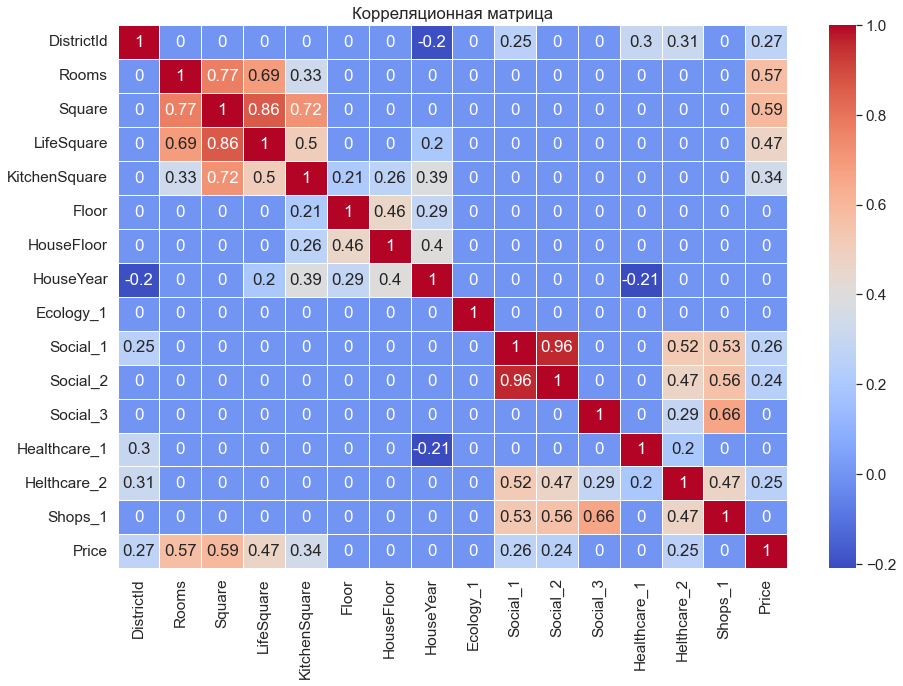

In [101]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Корреляционная матрица')
plt.show()

[Вернуться к Плану проекта](#plan)


## Обработка выбросов в датафрейме test_df

### Rooms<a class='anckor' id='Rooms_test_ejection'>
    
[Вернуться к анализу выброса](#Rooms_test_analysis)

У переменной Rooms в датафрейме test_df имеются 3-и значения с выбросами: Rooms=0 - 2, Rooms=17 - 1. Заменим эти значения на среднее из датафрейма train_df.

In [102]:
# расчёт среднего значения Rooms из датафрейма train_df
room_mean = round(train_df_pre['Rooms'].mean())
room_mean

2

In [103]:
# Заменим Rooms = 0 и Rooms = 17 на среднее значение из датафрейма train_df
test_df_pre.loc[(test_df_pre['Rooms'] == 0) | (test_df_pre['Rooms'] == 17), 'Rooms'] = room_mean
test_df_pre['Rooms'].value_counts()

2.0    2033
1.0    1769
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64

### Square<a class='anckor' id='Square_test_ejection'>
    
[Вернуться к анализу выброса](#Square_test_analysis)

Для выбросов переменной Square < 10 и Square > 150 проведём замену по схеме:

- Square = square_mean - среднее значение площади для однотипных квартир из датафрейма для обучения.

In [104]:
# расчёт средних площадей квартир из датафрейма для обучения
square_mean_1 = train_df_pre[(train_df_pre['Rooms'] == 1)].Square.mean()
square_mean_2 = train_df_pre[(train_df_pre['Rooms'] == 2)].Square.mean()
square_mean_3 = train_df_pre[(train_df_pre['Rooms'] == 3)].Square.mean()
square_mean_4 = train_df_pre[(train_df_pre['Rooms'] == 4)].Square.mean()
square_mean_5 = train_df_pre[(train_df_pre['Rooms'] == 5)].Square.mean()
square_mean_1, square_mean_2, square_mean_3, square_mean_4, square_mean_5

(41.30571746826172,
 56.5115966796875,
 76.96548461914062,
 97.6932601928711,
 113.6131591796875)

In [105]:
# Изменим Square < 10  на среднию площадь квартиры
test_df_pre.loc[(test_df_pre['Square'] < 10) & (test_df_pre['Rooms'] == 1), 'Square'] = square_mean_1
test_df_pre.loc[(test_df_pre['Square'] < 10) & (test_df_pre['Rooms'] == 2), 'Square'] = square_mean_2

In [106]:
# Изменим Square > 150  на среднию площадь квартиры
test_df_pre.loc[(test_df_pre['Square'] > 150) & (test_df_pre['Rooms'] == 1), 'Square'] = square_mean_1
test_df_pre.loc[(test_df_pre['Square'] > 150) & (test_df_pre['Rooms'] == 2), 'Square'] = square_mean_2
test_df_pre.loc[(test_df_pre['Square'] > 150) & (test_df_pre['Rooms'] == 3), 'Square'] = square_mean_3
test_df_pre.loc[(test_df_pre['Square'] > 150) & (test_df_pre['Rooms'] == 4), 'Square'] = square_mean_4
test_df_pre.loc[(test_df_pre['Square'] > 150) & (test_df_pre['Rooms'] == 5), 'Square'] = square_mean_5

test_df_pre[(test_df_pre['Square'] < 10) | (test_df_pre['Square'] > 150)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
956,4058,27,6.0,223.45369,104.113556,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B


### LifeSquare<a class='anckor' id='LifeSquare_test_ejection'>
    
[Вернуться к анализу выброса](#LifeSquare_test_analysis)

Переменная LifeSquare оказывает слабое влияние на целевую переменную, в связи с этим её можно удалить. Однако она может влиять на выбор квартиры клиентом, в связи с этим её выбросы заменим на значения согласно логике:

- для LifeSquare < 10 = 70% от общей площади квартиры;
- для LifeSquare >= Square = 70% от общей площади квартиры.

In [107]:
test_df_pre.loc[(test_df_pre['LifeSquare'] < 10), 'LifeSquare'] = test_df_pre['Square'] * 0.7
test_df_pre.loc[(test_df_pre['LifeSquare'] >= test_df_pre['Square']), 'LifeSquare'] = test_df_pre['Square'] * 0.7

### KitchenSquare<a class='anckor' id='KitchenSquare_test_ejection'>
    
[Вернуться к анализу выброса](#KitchenSquare_test_analysis)
    
Переменная KitchenSquare оказывает слабое влияние на целевую переменную, в связи с этим выброс её можно удалить. Однако она может влиять на выбор квартиры клиентом, в связи с этим её выбросы заменим на значения согласно логике:

- для KitchenSquare < 5 = 15% от общей площади квартиры;
- для KitchenSquare > 25 = 15% от общей площади квартиры.

In [108]:
test_df_pre.loc[(test_df_pre['KitchenSquare'] < 5) | (test_df_pre['KitchenSquare'] > 25), 'KitchenSquare'] = test_df_pre['Square'] * 0.15

### HouseFloor<a class='anckor' id='HouseFloor_test_ejection'>
    
[Вернуться к анализу выброса](#HouseFloor_test_analysis)
    
Переменная HouseFloor оказывает слабое влияние на целевую переменную, но имеет большое количество выбросов, при исправлении которых может усилится влияние. В связи с этим выброс = 0 заменим на значения согласно логике:

- HouseFloor = mean_floor - для квартир с Floor < mean_floor;
- HouseFloor = Floor - для квартир с Floor > mean_floor.

In [109]:
test_df_pre.loc[(test_df_pre['HouseFloor'] == 0) & (test_df_pre['Floor'] <= mean_floor), 'HouseFloor'] = mean_floor

In [110]:
test_df_pre.loc[(test_df_pre['HouseFloor'] == 0) & (test_df_pre['Floor'] > mean_floor), 'HouseFloor'] = test_df_pre['Floor']

In [111]:
test_df_pre.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.907800,56.380432,36.008923,8.264885,8.632000,12.90200,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,44.179466,0.810094,18.459772,14.902983,2.623099,5.483228,6.50239,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.745605,1.47994,4.777365
min,0.000000,1.000000,13.305532,9.313872,1.995830,1.000000,1.00000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906230,23.715912,6.000000,4.000000,9.00000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921339,32.937855,8.000000,7.000000,13.00000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.273626,44.872055,10.000000,12.000000,17.00000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,6.000000,223.453690,136.921097,24.000000,78.000000,99.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


[Вернуться к Плану проекта](#plan)

# Обработка пропусков<a class='anckor' id='process_nulls'>
       
## Обработка пропусков в датасете train_df<a class='anckor' id='process_train_nulls'>
    
### LifeSquare<a class='anckor' id='train_LifeSquare_nulls'>
    
[Вернуться к анализу пропусков](#train_nulls)
    
Переменная LifeSquare, имеющая 21,13% пропусков, согласно корреляционной матрицы на целевую переменную имеет очень слабое влияние. В связи с этим можно не обрабатывать пропуски, а удалим этот признак. Мы же заменим пропуски значением равным 70% от признака Square в текущей записи после исправления выбросов.

In [112]:
train_df_pre[train_df_pre['LifeSquare'].isnull()].shape

(2109, 20)

In [113]:
train_df_pre.loc[train_df_pre['LifeSquare'].isnull(), 'LifeSquare'] = train_df_pre['Square'] * 0.7
train_df_pre.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4779
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### Healthcare_1<a class='anckor' id='train_Healthcare_1_nulls'>
    
[Вернуться к анализу пропусков](#train_nulls)
    
Переменная Healthcare_1, имеющая 47.98% пропусков, согласно корреляционной матрицы на целевую переменную имеет слабое влияние. В связи с этим мы поэкспериментируем с заменой пропусков на значения: min, median или mean, что может усилить влияние на целевую переменную.

In [114]:
train_df_pre[train_df_pre['Healthcare_1'].isnull()].shape

(4779, 20)

Находим статистические значения для переменной Healthcare_1

In [115]:
mean_Healthcare_1 = train_df_pre['Healthcare_1'].mean()
min_Healthcare_1 = train_df_pre['Healthcare_1'].min()
median_Healthcare_1 = train_df_pre['Healthcare_1'].median()
mode_Healthcare_1 = train_df_pre['Healthcare_1'].mode()
min_Healthcare_1, mean_Healthcare_1, median_Healthcare_1, mode_Healthcare_1

(0.0,
 1142.586181640625,
 900.0,
 0    540.0
 dtype: float32)

Заменим пропуски для признака Healthcare_1 на min значение в датасете

In [116]:
train_df_pre_full = train_df_pre.copy()
train_df_pre_full.loc[train_df_pre_full['Healthcare_1'].isnull(), 'Healthcare_1'] = min_Healthcare_1

In [117]:
train_df_pre_full.isnull().mean() * 100

Id               0.0
DistrictId       0.0
Rooms            0.0
Square           0.0
LifeSquare       0.0
KitchenSquare    0.0
Floor            0.0
HouseFloor       0.0
HouseYear        0.0
Ecology_1        0.0
Ecology_2        0.0
Ecology_3        0.0
Social_1         0.0
Social_2         0.0
Social_3         0.0
Healthcare_1     0.0
Helthcare_2      0.0
Shops_1          0.0
Shops_2          0.0
Price            0.0
dtype: float64

In [118]:
train_df_pre_full.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000,9969.000000
mean,50.446083,1.888053,56.164253,37.119057,8.324496,8.522219,12.914234,1984.839502,0.118873,24.695556,5353.524125,8.045341,594.846252,1.319791,4.231317,214039.015625
std,43.615393,0.810677,18.817644,15.101613,2.673012,5.231607,6.469488,18.404931,0.119119,17.522420,4004.259600,23.828843,931.890625,1.493583,4.805263,92711.851562
min,0.000000,1.000000,13.784864,9.649405,2.417573,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.783810,26.257957,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,0.000000,1.000000,153893.984375
50%,36.000000,2.000000,52.524544,33.665432,8.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,30.000000,1.000000,3.000000,192248.078125
75%,75.000000,2.000000,65.889572,45.599220,10.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249093.781250
max,209.000000,5.000000,198.930176,161.504227,28.003891,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [119]:
# посчитаем коэффициент корреляции для всего датафрейма и округлим значение
corr_matrix = train_df_pre_full.corr().round(2)
corr_matrix

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
DistrictId,1.00,0.08,-0.03,-0.09,-0.11,-0.12,-0.17,-0.20,0.07,0.25,0.17,0.14,0.30,0.31,0.17,0.27
Rooms,0.08,1.00,0.77,0.69,0.33,-0.01,-0.04,-0.05,-0.03,0.08,0.07,0.01,0.05,0.06,0.05,0.57
Square,-0.03,0.77,1.00,0.89,0.72,0.12,0.11,0.19,-0.07,-0.08,-0.05,0.02,-0.05,-0.03,0.01,0.59
LifeSquare,-0.09,0.69,0.89,1.00,0.61,0.11,0.06,0.15,-0.07,-0.18,-0.15,0.04,-0.09,-0.10,-0.02,0.45
KitchenSquare,-0.11,0.33,0.72,0.61,1.00,0.21,0.26,0.39,-0.08,-0.15,-0.10,-0.00,-0.13,-0.11,-0.03,0.34
Floor,-0.12,-0.01,0.12,0.11,0.21,1.00,0.46,0.29,-0.02,-0.05,-0.02,-0.00,-0.12,-0.07,0.02,0.13
HouseFloor,-0.17,-0.04,0.11,0.06,0.26,0.46,1.00,0.40,-0.02,-0.06,-0.03,-0.02,-0.13,-0.10,0.00,0.09
HouseYear,-0.20,-0.05,0.19,0.15,0.39,0.29,0.40,1.00,-0.07,-0.05,0.01,-0.05,-0.21,-0.12,-0.00,0.04
Ecology_1,0.07,-0.03,-0.07,-0.07,-0.08,-0.02,-0.02,-0.07,1.00,0.03,0.01,-0.12,0.12,0.03,-0.08,-0.06
Social_1,0.25,0.08,-0.08,-0.18,-0.15,-0.05,-0.06,-0.05,0.03,1.00,0.96,0.02,0.16,0.52,0.53,0.26


[Вернуться к Плану проекта](#plan)

### Обработка пропусков в датасете test_df<a class='anckor' id='process_test_nulls'>
    
### LifeSquare<a class='anckor' id='test_LifeSquare_nulls'>
    
[Вернуться к анализу пропусков](#test_nulls)
    
Переменная LifeSquare, имеющая 20.82% пропусков. Заполним пропуска значением равным 70% от признака Square в текущей записи после исправления выбросов.

In [120]:
test_df_pre[test_df_pre['LifeSquare'].isnull()].shape

(1041, 19)

In [121]:
test_df_pre.loc[test_df_pre['LifeSquare'].isnull(), 'LifeSquare'] = test_df_pre['Square'] * 0.7
test_df_pre.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

### Healthcare_1<a class='anckor' id='test_Healthcare_1_nulls'>
    
[Вернуться к анализу пропусков](#test_nulls)
    
Переменная Healthcare_1, имеющая 47.54% пропусков. Заполним пропуска значением, которым заполняли пропуска в датафрейме train_df.

In [122]:
test_df_pre_full = test_df_pre.copy()
test_df_pre_full.loc[test_df_pre_full['Healthcare_1'].isnull(), 'Healthcare_1'] = min_Healthcare_1
test_df_pre_full.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [123]:
test_df_pre_full.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,51.279200,1.907800,56.380432,37.304497,8.264885,8.632000,12.90200,1984.392600,0.119874,24.933800,5406.900000,8.262600,601.536377,1.31940,4.242800
std,44.179466,0.810094,18.459772,14.766777,2.623099,5.483228,6.50239,18.573149,0.120070,17.532202,4026.614773,23.863762,948.919922,1.47994,4.777365
min,0.000000,1.000000,13.305532,9.313872,1.995830,1.000000,1.00000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906230,26.469241,6.000000,4.000000,9.00000,1973.000000,0.019509,6.000000,1564.000000,0.000000,0.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921339,34.068201,8.000000,7.000000,13.00000,1977.000000,0.072158,25.000000,5285.000000,2.000000,30.000000,1.00000,3.000000
75%,77.000000,2.000000,66.273626,45.838554,10.000000,12.000000,17.00000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000
max,212.000000,6.000000,223.453690,136.921097,24.000000,78.000000,99.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


[Вернуться к Плану проекта](#plan)

## Генерация новых признаков<a class='anckor' id='new_cat'>

### Кодирование категориальных признаков.

#### Унитарное кодирование (One Hot Encoding) датафрейма train_df

In [124]:
train_df_cod = pd.get_dummies(train_df_pre_full, columns=["Ecology_2", "Ecology_3", "Shops_2"], prefix=["Ec2", "Ec3", "Sh"])
train_df_cod.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B
0,11809,27,3.0,115.027313,80.519119,10.000000,4,10.0,2014,0.075424,...,0.0,0,0,305018.875000,0,1,0,1,0,1
1,3013,22,1.0,39.832523,23.169222,8.000000,7,8.0,1966,0.118537,...,1183.0,1,0,177734.546875,0,1,0,1,0,1
2,8215,1,3.0,78.342216,47.671970,10.000000,2,17.0,1988,0.025609,...,240.0,3,1,282078.718750,0,1,0,1,0,1
3,2352,1,1.0,40.409908,28.286936,6.061487,10,22.0,1977,0.007122,...,0.0,0,1,168106.000000,0,1,0,1,0,1
4,13866,94,2.0,64.285065,38.562515,9.000000,16,16.0,1972,0.282798,...,0.0,0,6,343995.093750,0,1,0,1,0,1


In [125]:
train_df_cod.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price', 'Ec2_A',
       'Ec2_B', 'Ec3_A', 'Ec3_B', 'Sh_A', 'Sh_B'],
      dtype='object')

#### Создание нового признака Price_sqr_meter

Price_sqr_meter = price_mean / Square - **стоимость квадратного метра**. Price_mean - расчитывается для различных квартир

In [126]:
# расчёт средней стоимости квартир из датафрейма для обучения
price_mean_1 = train_df_pre[(train_df_pre['Rooms'] == 1)].Price.mean()
price_mean_2 = train_df_pre[(train_df_pre['Rooms'] == 2)].Price.mean()
price_mean_3 = train_df_pre[(train_df_pre['Rooms'] == 3)].Price.mean()
price_mean_4 = train_df_pre[(train_df_pre['Rooms'] == 4)].Price.mean()
price_mean_5 = train_df_pre[(train_df_pre['Rooms'] == 5)].Price.mean()
price_mean_1, price_mean_2, price_mean_3, price_mean_4, price_mean_5

(159600.515625, 215252.296875, 289403.15625, 382275.8125, 407794.3125)

In [127]:
train_df_sqr = train_df_cod.copy()
train_df_sqr.loc[train_df_sqr['Rooms'] == 1, 'Price_sqr_meter'] = price_mean_1 / train_df_sqr['Square']
train_df_sqr.loc[train_df_sqr['Rooms'] == 2, 'Price_sqr_meter'] = price_mean_2 / train_df_sqr['Square']
train_df_sqr.loc[train_df_sqr['Rooms'] == 3, 'Price_sqr_meter'] = price_mean_3 / train_df_sqr['Square']
train_df_sqr.loc[train_df_sqr['Rooms'] == 4, 'Price_sqr_meter'] = price_mean_4 / train_df_sqr['Square']
train_df_sqr.loc[train_df_sqr['Rooms'] >= 5, 'Price_sqr_meter'] = price_mean_5 / train_df_sqr['Square']
train_df_sqr.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Price,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B,Price_sqr_meter
0,11809,27,3.0,115.027313,80.519119,10.000000,4,10.0,2014,0.075424,...,0,0,305018.875000,0,1,0,1,0,1,2515.951660
1,3013,22,1.0,39.832523,23.169222,8.000000,7,8.0,1966,0.118537,...,1,0,177734.546875,0,1,0,1,0,1,4006.789062
2,8215,1,3.0,78.342216,47.671970,10.000000,2,17.0,1988,0.025609,...,3,1,282078.718750,0,1,0,1,0,1,3694.089355
3,2352,1,1.0,40.409908,28.286936,6.061487,10,22.0,1977,0.007122,...,0,1,168106.000000,0,1,0,1,0,1,3949.539062
4,13866,94,2.0,64.285065,38.562515,9.000000,16,16.0,1972,0.282798,...,0,6,343995.093750,0,1,0,1,0,1,3348.402832


#### Унитарное кодирование (One Hot Encoding) датафрейма test_df

In [128]:
test_df_cod = pd.get_dummies(test_df_pre_full, columns=["Ecology_2", "Ecology_3", "Shops_2"], prefix=["Ec2", "Ec3", "Sh"])
test_df_cod.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B
0,4567,44,1.0,36.847630,19.094183,5.000000,5,9.0,1970,0.036122,...,0,1036.0,1,1,0,1,0,1,0,1
1,5925,62,1.0,42.493908,29.745735,10.000000,7,17.0,2017,0.072158,...,1,0.0,0,0,0,1,0,1,1,0
2,960,27,2.0,59.463676,41.624573,9.000000,19,19.0,1977,0.211401,...,0,0.0,0,1,0,1,0,1,0,1
3,3848,23,3.0,49.646030,33.893826,6.000000,2,2.0,1965,0.014073,...,0,0.0,0,0,0,1,0,1,0,1
4,746,74,1.0,53.837055,37.685940,8.075559,8,17.0,1977,0.309479,...,4,990.0,0,6,0,1,0,1,0,1


In [129]:
test_df_cod.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ec2_A', 'Ec2_B',
       'Ec3_A', 'Ec3_B', 'Sh_A', 'Sh_B'],
      dtype='object')

#### Создание нового признака Price_sqr_meter

Price_sqr_meter = price_mean / Square - **стоимость квадратного метра**. Price_mean - расчитывается для различных квартир из датафрейма для обучения

In [130]:
test_df_sqr = test_df_cod.copy()
test_df_sqr.loc[test_df_sqr['Rooms'] == 1, 'Price_sqr_meter'] = price_mean_1 / test_df_sqr['Square']
test_df_sqr.loc[test_df_sqr['Rooms'] == 2, 'Price_sqr_meter'] = price_mean_2 / test_df_sqr['Square']
test_df_sqr.loc[test_df_sqr['Rooms'] == 3, 'Price_sqr_meter'] = price_mean_3 / test_df_sqr['Square']
test_df_sqr.loc[test_df_sqr['Rooms'] == 4, 'Price_sqr_meter'] = price_mean_4 / test_df_sqr['Square']
test_df_sqr.loc[test_df_sqr['Rooms'] >= 5, 'Price_sqr_meter'] = price_mean_5 / test_df_sqr['Square']
test_df_sqr.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B,Price_sqr_meter
0,4567,44,1.0,36.847630,19.094183,5.000000,5,9.0,1970,0.036122,...,1036.0,1,1,0,1,0,1,0,1,4331.364746
1,5925,62,1.0,42.493908,29.745735,10.000000,7,17.0,2017,0.072158,...,0.0,0,0,0,1,0,1,1,0,3755.844727
2,960,27,2.0,59.463676,41.624573,9.000000,19,19.0,1977,0.211401,...,0.0,0,1,0,1,0,1,0,1,3619.895508
3,3848,23,3.0,49.646030,33.893826,6.000000,2,2.0,1965,0.014073,...,0.0,0,0,0,1,0,1,0,1,5829.331055
4,746,74,1.0,53.837055,37.685940,8.075559,8,17.0,1977,0.309479,...,990.0,0,6,0,1,0,1,0,1,2964.510498


In [131]:
test_df_sqr.shape

(5000, 23)

[Вернуться к Плану проекта](#plan)

### Отбор признаков<a class='anckor' id='feature_selection'>

In [132]:
train_df_sqr.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ec2_A',
 'Ec2_B',
 'Ec3_A',
 'Ec3_B',
 'Sh_A',
 'Sh_B',
 'Price_sqr_meter']

In [133]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 
                 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 
                 'Shops_1', 'Ec2_A', 'Ec2_B', 'Ec3_A', 'Ec3_B', 'Sh_A', 'Sh_B']

new_feature_names = ['Price_sqr_meter']

target_name = 'Price'

In [134]:
train_df_sqr = train_df_sqr[feature_names + new_feature_names + [target_name]]
train_df_sqr.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2,Shops_1,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B,Price_sqr_meter,Price
0,27,3.0,115.027313,80.519119,10.000000,4,10.0,2014,0.075424,11,...,0,0,0,1,0,1,0,1,2515.951660,305018.875000
1,22,1.0,39.832523,23.169222,8.000000,7,8.0,1966,0.118537,30,...,1,0,0,1,0,1,0,1,4006.789062,177734.546875
2,1,3.0,78.342216,47.671970,10.000000,2,17.0,1988,0.025609,33,...,3,1,0,1,0,1,0,1,3694.089355,282078.718750
3,1,1.0,40.409908,28.286936,6.061487,10,22.0,1977,0.007122,1,...,0,1,0,1,0,1,0,1,3949.539062,168106.000000
4,94,2.0,64.285065,38.562515,9.000000,16,16.0,1972,0.282798,33,...,0,6,0,1,0,1,0,1,3348.402832,343995.093750


In [135]:
train_df_sqr.shape

(9969, 23)

In [136]:
test_df_sqr = test_df_sqr[feature_names + new_feature_names]
test_df_sqr.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B,Price_sqr_meter
0,44,1.0,36.847630,19.094183,5.000000,5,9.0,1970,0.036122,24,...,1036.0,1,1,0,1,0,1,0,1,4331.364746
1,62,1.0,42.493908,29.745735,10.000000,7,17.0,2017,0.072158,2,...,0.0,0,0,0,1,0,1,1,0,3755.844727
2,27,2.0,59.463676,41.624573,9.000000,19,19.0,1977,0.211401,9,...,0.0,0,1,0,1,0,1,0,1,3619.895508
3,23,3.0,49.646030,33.893826,6.000000,2,2.0,1965,0.014073,2,...,0.0,0,0,0,1,0,1,0,1,5829.331055
4,74,1.0,53.837055,37.685940,8.075559,8,17.0,1977,0.309479,35,...,990.0,0,6,0,1,0,1,0,1,2964.510498


In [137]:
test_df_sqr.shape

(5000, 22)

### Сохранение подготовленных данных<a class='anckor' id='save_dataset'>

In [138]:
train_df_sqr.to_csv(PREPARED_TRAIN_PATH, sep=',', index=False, encoding='utf-8')

test_df_sqr.to_csv(PREPARED_TEST_PATH, sep=',', index=False, encoding='utf-8')

[Вернуться к Плану проекта](#plan)

### Разделение датафрейма train на train и valid<a class='anckor' id='separ'>


In [139]:
df = pd.read_csv(PREPARED_TRAIN_PATH, sep=',')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2,Shops_1,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B,Price_sqr_meter,Price
0,27,3.0,115.027310,80.519120,10.000000,4,10.0,2014,0.075424,11,...,0,0,0,1,0,1,0,1,2515.9517,305018.88
1,22,1.0,39.832523,23.169222,8.000000,7,8.0,1966,0.118537,30,...,1,0,0,1,0,1,0,1,4006.7890,177734.55
2,1,3.0,78.342220,47.671970,10.000000,2,17.0,1988,0.025609,33,...,3,1,0,1,0,1,0,1,3694.0894,282078.72
3,1,1.0,40.409910,28.286936,6.061487,10,22.0,1977,0.007122,1,...,0,1,0,1,0,1,0,1,3949.5390,168106.00
4,94,2.0,64.285065,38.562515,9.000000,16,16.0,1972,0.282798,33,...,0,6,0,1,0,1,0,1,3348.4028,343995.10


In [140]:
reduce_mem_usage(df)
df.dtypes

Исходным датафреймом использована память в размере: 1.75 MB
Оптимизированным датафреймом использована память в размере: 0.51 MB
Использованная датафреймом память уменьшилась на 70.6%


DistrictId           int16
Rooms              float32
Square             float32
LifeSquare         float32
KitchenSquare      float32
Floor                 int8
HouseFloor         float32
HouseYear            int16
Ecology_1          float32
Social_1              int8
Social_2             int16
Social_3             int16
Healthcare_1       float32
Helthcare_2           int8
Shops_1               int8
Ec2_A                 int8
Ec2_B                 int8
Ec3_A                 int8
Ec3_B                 int8
Sh_A                  int8
Sh_B                  int8
Price_sqr_meter    float32
Price              float32
dtype: object

In [141]:
X = df[feature_names + new_feature_names]
y = df[target_name]
X.shape, y.shape

((9969, 22), (9969,))

In [142]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((6679, 22), (6679,), (3290, 22), (3290,))

In [143]:
X_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B,Price_sqr_meter
5972,111,1.0,41.312321,16.194496,9.000000,19,21.0,2007,0.093443,23,...,3300.0,2,4,0,1,0,1,0,1,3863.266846
8375,96,3.0,79.894508,50.964649,10.000000,19,17.0,2005,0.041116,53,...,0.0,1,4,0,1,0,1,0,1,3622.315918
9415,53,3.0,80.488808,77.987732,12.073321,5,19.0,1977,0.049637,34,...,229.0,1,3,0,1,0,1,0,1,3595.570068
7202,171,1.0,44.824615,18.784719,9.000000,19,25.0,1975,0.019509,37,...,176.0,5,5,0,1,0,1,0,1,3560.555176
2626,107,2.0,56.869190,33.552521,8.000000,13,14.0,1971,0.174739,17,...,100.0,0,3,0,1,0,1,0,1,3785.042480


[Вернуться к Плану проекта](#plan)

## Построение модели<a class='anckor' id='models'>

In [144]:
rf_model = RandomForestRegressor(random_state=42)

[Вернуться к Плану проекта](#plan)

### Обучение и валидация модели<a class='anckor' id='train'>

In [145]:
%%time

rf_model.fit(X_train, y_train)

CPU times: user 4.04 s, sys: 15.2 ms, total: 4.06 s
Wall time: 4.06 s


RandomForestRegressor(random_state=42)

Теперь, когда модель обучена, мы можем получить предсказанные значения на объектах `X_valid` с помощью метода `.predict`:

In [146]:
y_valid_pred = rf_model.predict(X_valid)
y_train_pred = rf_model.predict(X_train)
y_valid_pred.shape, y_train_pred.shape

((3290,), (6679,))

Train R2:	0.962
Train RMSE:	18092.605
Train MSE:	327342371.659

Test R2:	0.704
Test RMSE:	50420.393
Test MSE:	2542216034.398


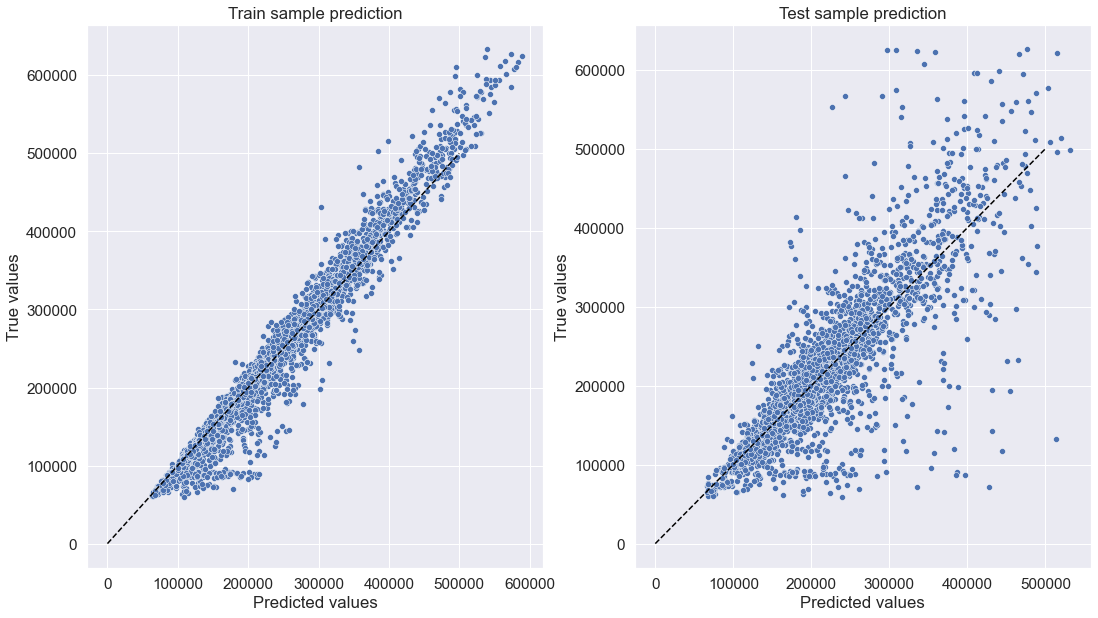

In [147]:
evaluate_preds(y_train, y_train_pred, y_valid, y_valid_pred)

**Перекрёстная проверка**

In [148]:
%%time

cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

CPU times: user 12.2 s, sys: 42.9 ms, total: 12.2 s
Wall time: 12.2 s


array([0.70881768, 0.72115394, 0.72588948])

In [149]:
cv_score.mean()

0.7186203692304095

[Вернуться к Плану проекта](#plan)

### Важность признаков<a class='anckor' id='importance_signs'>

In [150]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.375518
10,Social_2,0.114993
9,Social_1,0.081043
1,Rooms,0.072033
11,Social_3,0.056040
8,Ecology_1,0.043064
21,Price_sqr_meter,0.037783
0,DistrictId,0.034398
3,LifeSquare,0.034241
7,HouseYear,0.031913


In [151]:
feature_importances.sum()

feature_name    DistrictIdRoomsSquareLifeSquareKitchenSquareFl...
importance                                                    1.0
dtype: object

Сумма всех показателей важности равна **1**.

Из массива показателей важности следует, что признаки **'Square'** и **'Social_2'** имеют найбольшую важность.

[Вернуться к Плану проекта](#plan)

### Прогнозирование на тестовом датафрейме<a class='anckor' id='prediction'>

In [152]:
X_test = pd.read_csv(PREPARED_TEST_PATH)
X_test.shape

(5000, 22)

In [153]:
reduce_mem_usage(X_test)

Исходным датафреймом использована память в размере: 0.84 MB
Оптимизированным датафреймом использована память в размере: 0.24 MB
Использованная датафреймом память уменьшилась на 71.6%


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ec2_A,Ec2_B,Ec3_A,Ec3_B,Sh_A,Sh_B,Price_sqr_meter
0,44,1.0,36.847630,19.094183,5.000000,5,9.0,1970,0.036122,24,...,1036.0,1,1,0,1,0,1,0,1,4331.364746
1,62,1.0,42.493908,29.745735,10.000000,7,17.0,2017,0.072158,2,...,0.0,0,0,0,1,0,1,1,0,3755.844727
2,27,2.0,59.463676,41.624573,9.000000,19,19.0,1977,0.211401,9,...,0.0,0,1,0,1,0,1,0,1,3619.895508
3,23,3.0,49.646030,33.893826,6.000000,2,2.0,1965,0.014073,2,...,0.0,0,0,0,1,0,1,0,1,5829.331055
4,74,1.0,53.837055,37.685940,8.075559,8,17.0,1977,0.309479,35,...,990.0,0,6,0,1,0,1,0,1,2964.510498


In [154]:
y_test_preds = rf_model.predict(X_test)
y_test_preds.shape

(5000,)

In [155]:
predictions = pd.DataFrame({"Id": np.arange(len(y_test_preds)), "Price": y_test_preds})
predictions.head()

,Id,Price
0,0,154857.711875
1,1,118536.592734
2,2,137545.938672
3,3,138766.905312
4,4,193994.748906


In [156]:
predictions.to_csv('SKoptev_predictions.csv', sep=',', index=False, encoding='utf-8')